<a href="https://colab.research.google.com/github/omar80-coder/Document-validation-Stamp-and-Signature-detection-using-Deep-Learning-/blob/main/inference_Retinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Inference time: 8.811 seconds


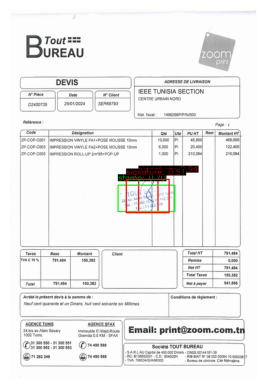

In [ ]:
import torchvision
import torch
from functools import partial
from torchvision.models.detection import RetinaNet_ResNet50_FPN_V2_Weights
from torchvision.models.detection.retinanet import RetinaNetClassificationHead
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time

# Set device
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Define paths and parameters
image_path = '/content/drive/MyDrive/PFA Work - ML Invoice Validation/Assets and datasets/P2_MACHINE_resized_images_PNG/devis_events-11.pdf_1.png'
Handwrittençimg_path='/content/drive/MyDrive/PFA Work - ML Invoice Validation/Assets and datasets/P2_HANDWRITTEN_resized_images_PNG/20231217_190133_merged-2.pdf_1.png'
threshold = 0.3
COLORS = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
CLASSES = ['__background__', 'stamp', 'signature']
NUM_CLASSES = len(CLASSES)

# Function to create the model
def create_model(num_classes):
    model = torchvision.models.detection.retinanet_resnet50_fpn_v2(weights=RetinaNet_ResNet50_FPN_V2_Weights.COCO_V1)
    num_anchors = model.head.classification_head.num_anchors

    model.head.classification_head = RetinaNetClassificationHead(
        in_channels=256,
        num_anchors=num_anchors,
        num_classes=num_classes,
        norm_layer=partial(torch.nn.GroupNorm, 32)
    )
    return model

# Load the model
model = create_model(num_classes=NUM_CLASSES)
checkpoint = torch.load('/content/drive/MyDrive/PFA Work - ML Invoice Validation/Advancements/Wissal/best_model.pth', map_location=DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model = model.to(DEVICE).eval()

# Read and process the image
image = cv2.imread(image_path)
orig_image = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
image_input = np.transpose(image, (2, 0, 1)).astype(np.float32)
image_input = torch.tensor(image_input, dtype=torch.float).to(DEVICE)
image_input = torch.unsqueeze(image_input, 0)  # Add batch dimension

# Perform inference
start_time = time.time()
with torch.no_grad():
    outputs = model(image_input)
end_time = time.time()
inference_time = end_time - start_time
print(f"Inference time: {inference_time:.3f} seconds")

# Post-process the outputs
boxes = outputs[0]['boxes'].data.cpu().numpy()
scores = outputs[0]['scores'].data.cpu().numpy()
labels = outputs[0]['labels'].data.cpu().numpy()

# Filter boxes by threshold
filtered_indices = scores >= threshold
boxes = boxes[filtered_indices].astype(np.int32)
scores = scores[filtered_indices]
pred_classes = [CLASSES[i] for i in labels[filtered_indices]]

# Draw boxes, labels, and scores on the image
def draw_bounding_box_with_text(img, box, class_name, score, color):
    xmin, ymin, xmax, ymax = box
    cv2.rectangle(img, (xmin, ymin), (xmax, ymax), color, 2)
    label_text = f"{class_name}: {score:.2f}"
    text_width, text_height = cv2.getTextSize(label_text, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)[0]
    text_offset_x = xmin
    text_offset_y = ymin - 10
    text_background_color = (0, 0, 0)
    cv2.rectangle(img, (text_offset_x, text_offset_y - text_height - 2), (text_offset_x + text_width, text_offset_y), text_background_color, -1)
    cv2.putText(img, label_text, (text_offset_x, text_offset_y - 2), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 1)

for box, class_name, score in zip(boxes, pred_classes, scores):
    color = COLORS[CLASSES.index(class_name) % len(COLORS)]
    box = [int(box[0] * orig_image.shape[1] / image.shape[1]),
           int(box[1] * orig_image.shape[0] / image.shape[0]),
           int(box[2] * orig_image.shape[1] / image.shape[1]),
           int(box[3] * orig_image.shape[0] / image.shape[0])]
    draw_bounding_box_with_text(orig_image, box, class_name, score, color)

# Display the image
plt.imshow(cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
